## IRIS analysis

Create a bed file that tiles every gene, on the antisense strand, in 500nt increments (250nt step-size).

In [ ]:
ls -al genome

In [ ]:
%%bash
head Human.GRC38.96_cDNA_longest_CDS.fa

In [12]:
import sys 
import os 
import subprocess 
import pandas as pd 
import numpy as np 
from Bio import SeqIO 
import gzip 
from glob import glob 
import re 

In [ ]:
with open("genome/Human.GRC38.96_cDNA_longest_CDS.fa", "rt") as handle, open("genome/Human.GRC38.96_antisense.bed", "wt") as bed:
    for record in SeqIO.parse(handle, "fasta"):
        #print(record.id, len(record.seq))
        for k,i in enumerate(range(0,len(record.seq)-250,250)):
            bed.write("{}\t{}\t{}\t{}-{}\t1\t-\n".format(record.id, i, min(i+500, len(record.seq)), record.id, k+1))

In [ ]:
%%bash
head genome/Human.GRC38.96_antisense.bed

## GROseq data
Analyze GROseq data from MDA-MB-231 cells (two replicate experiments).

In [ ]:
%%bash
samtools view GROseq/MDA_GROseq_r1.bam | awk '{if($2==0) print}' | cut -f3 | sort | uniq -c |  awk '{ print $2 "\t" $1}' > GROseq/MDA_GROseq_r1.sense.gene.cnt
samtools view GROseq/MDA_GROseq_r2.bam | awk '{if($2==0) print}' | cut -f3 | sort | uniq -c |  awk '{ print $2 "\t" $1}' > GROseq/MDA_GROseq_r2.sense.gene.cnt
samtools view GROseq/MDA_GROseq_r1.bam | awk '{if($2==16) print}' | cut -f3 | sort | uniq -c |  awk '{ print $2 "\t" $1}' > GROseq/MDA_GROseq_r1.antisense.gene.cnt
samtools view GROseq/MDA_GROseq_r2.bam | awk '{if($2==16) print}' | cut -f3 | sort | uniq -c |  awk '{ print $2 "\t" $1}' > GROseq/MDA_GROseq_r2.antisense.gene.cnt

In [ ]:
%%bash
bamToBed -i GROseq/MDA_GROseq_r1.bam > GROseq/MDA_GROseq_r1.bed
bamToBed -i GROseq/MDA_GROseq_r2.bam > GROseq/MDA_GROseq_r2.bed

In [ ]:
%%bash
intersectBed -f 1 -S -wo -a GROseq/MDA_GROseq_r1.bed -b genome/Human.GRC38.96_antisense_frags.bed | cut -f10 | sort | uniq -c |  awk '{ print $2 "\t" $1}' > GROseq/MDA_GROseq_r1.sense.frag.cnt
intersectBed -f 1 -S -wo -a GROseq/MDA_GROseq_r2.bed -b genome/Human.GRC38.96_antisense_frags.bed | cut -f10 | sort | uniq -c |  awk '{ print $2 "\t" $1}' > GROseq/MDA_GROseq_r2.sense.frag.cnt
intersectBed -f 1 -s -wo -a GROseq/MDA_GROseq_r1.bed -b genome/Human.GRC38.96_antisense_frags.bed | cut -f10 | sort | uniq -c |  awk '{ print $2 "\t" $1}' > GROseq/MDA_GROseq_r1.antisense.frag.cnt
intersectBed -f 1 -s -wo -a GROseq/MDA_GROseq_r2.bed -b genome/Human.GRC38.96_antisense_frags.bed | cut -f10 | sort | uniq -c |  awk '{ print $2 "\t" $1}' > GROseq/MDA_GROseq_r2.antisense.frag.cnt

In [1]:
%load_ext rpy2.ipython
import warnings
warnings.filterwarnings('ignore')

/avicenna/hani/anaconda3/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:17: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


In [ ]:
%%R -o frag.df
files <- list.files("./GROseq", pattern=".frag.cnt$")
files <- paste0("./GROseq/", files)
datalist <- lapply(files, function(x){read.table(file=x,header=FALSE,col.names=c("frag", sub("./GROseq/(\\S+)\\.cnt", "\\1", x)))})
m <- Reduce(function(...) merge(..., by=1, all = TRUE), datalist)
rownames(m) <- m[,1]
m <- m[,-1]
m[is.na(m)]<-0
tmp <- m
tmp[tmp>0] <- 1
frag.df <- data.frame(m[rowSums(tmp)==4,])
frag.df$frag <- rownames(frag.df)
head(frag.df)

In [ ]:
%%R -o gene.df
files <- list.files("./GROseq", pattern="gene.cnt$")
files <- paste0("./GROseq/", files)
datalist <- lapply(files, function(x){read.table(file=x,header=FALSE,col.names=c("frag", sub("./GROseq/(\\S+)\\.cnt", "\\1", x)))})
m <- Reduce(function(...) merge(..., by=1, all = TRUE), datalist)
rownames(m) <- m[,1]
m <- m[,-1]
m[is.na(m)]<-0
tmp <- m
tmp[tmp>0] <- 1
gene.df <- data.frame(m[rowSums(tmp)==4,])
gene.df$gene <- rownames(gene.df)
head(gene.df)

In [ ]:
%%R -i frag.df,gene.df -o merged.df
library(tidyverse)
frag.df$gene <- gsub("-\\d+$", "", frag.df$frag)

merged.df <- frag.df %>% inner_join(gene.df, by="gene")
merged.df <- merged.df[,c(5,1,2,3,4,7,8,9,10)]
merged.df[,6] <- merged.df[,6]-merged.df[,2]
merged.df[,7] <- merged.df[,7]-merged.df[,3]
merged.df[,8] <- merged.df[,8]-merged.df[,4]
merged.df[,9] <- merged.df[,9]-merged.df[,5]
head(merged.df)

In [ ]:
%%R -i merged.df -o fit.s
logit.all<-function(x, design, model, feature.list){
  logit.all.gene<-function(m){
    prep<-data.frame(design,m)
    fit<-glm(model, data=prep, family="binomial"(link="logit"), weights = m)
    sfit<<-summary(fit)
    return(c(t(sfit$coefficients)))
  }
  logit.all.gene_try<-function(m){
    out<-tryCatch(
      {
        result_logistic<-logit.all.gene(m)
      },
      error=function(cond){
        return(rep(NA, times=8))
      }
    )
    return(out)
  }
  logit.x<-t(apply(x, 1, logit.all.gene_try))
  colnames(logit.x)<-apply(expand.grid(colnames(sfit$coefficients), rownames(sfit$coefficients)), 1, paste, collapse=".")
  rownames(logit.x)<-feature.list
  return(logit.x)
}

meta <- data.frame( do.call( rbind, strsplit( colnames(merged.df), '\\.' )[-1] ) )
colnames(meta) <- c('sample', 'strand', 'feature.type')
meta$feature.type <- factor(meta$feature.type)
meta$feature.type <- relevel(meta$feature.type, ref='gene')
meta$strand <- factor(meta$strand)
meta$strand <- relevel(meta$strand, ref='sense')

fit <- logit.all( merged.df[,-1], meta, feature.type~strand,  merged.df$frag)
fit.s <- fit[,c(5,8)]
colnames(fit.s) <- c("logASR", "P")
fit.s <- cbind(fit.s, p.adjust(fit.s[,'P'], method="fdr"))
colnames(fit.s) <- c("logASR", "P", "q")
write.table(fit.s, "GROseq/frag_gene_logASR_logit.txt", quote = F, sep="\t", row.names = T, col.names =NA) #ASR=antisense-sense ratio aka enrichment score
fit.s <- as.data.frame(fit.s)
fit.s$frag <- rownames(fit.s)
head(fit)

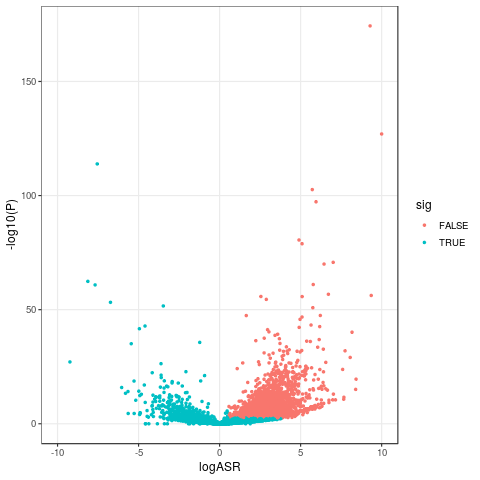

In [38]:
%%R
library(tidyverse)
m <- read_tsv('GROseq/frag_gene_logASR_logit.txt')
m <- m %>% mutate(sig = ifelse(logASR>0.5 & q<0.01, FALSE, TRUE) )
m %>% ggplot(aes(x=logASR, y=-log10(P), color=sig)) + geom_point(size=1) +xlim(c(-10,10)) + theme_bw(12) + theme(panel.grid.minor = element_blank())
#ggsave("GROseq/frag_gene_logASR_logit_volcano.pdf", useDingbats=F, width=4, height=3)

In [ ]:
%%R -i fit.s -o bed.c
library(tidyverse)
bed <- read_tsv('genome/Human.GRC38.96_antisense_frags.bed', col_names=F)
colnames(bed) <- c("chr", "start", "end", "frag", "dummy", "strand")
bed.f <- bed %>% inner_join(fit.s, by='frag')
bed.f <- bed.f %>% filter(logASR>0.5, q<0.01)
bed.f <- bed.f %>% mutate(dummy=round(-log10(q)))
write_tsv(bed.f %>% dplyr::select(chr, start,end,frag,dummy, strand), 'GROseq/Human.GRC38.96_antisense_frags.sig.bed', col_names=F)
head(bed.f)
#fit.s[startsWith(fit.s$frag, 'ENST00000320623'),]

In [ ]:
%%R -i fit.s
library(tidyverse)
bed <- read_tsv('genome/Human.GRC38.96_antisense_frags.bed', col_names=F)
colnames(bed) <- c("chr", "start", "end", "frag", "dummy", "strand")
bed.c <- bed %>% inner_join(fit.s, by='frag')
bed.c <- bed.c %>% filter(logASR< 0, q>0.5)
bed.c <- bed.c %>% mutate(dummy=round(-log10(q)))
write_tsv(bed.c %>% dplyr::select(chr, start,end,frag,dummy, strand), 'GROseq/Human.GRC38.96_antisense_frags.neg.control.bed', col_names=F)
head(bed.f)

In [ ]:
%%bash
#-d 300 allows meging of fragments that are close 
mergeBed -d 300 -c 4,6 -o collapse,distinct -i GROseq/Human.GRC38.96_antisense_frags.sig.bed | awk '{print $1 "\t" $2 "\t" $3 "\t" $1":"$2"-"$3 "\t1\t" $5 "\t" $4 }' > GROseq/Human.GRC38.96_antisense_frags.sig.merge.bed
head GROseq/Human.GRC38.96_antisense_frags.sig.merge.bed

In [ ]:
%%bash
wc -l GROseq/Human.GRC38.96_antisense_frags.sig.merge.bed

In [ ]:
%%bash
#-d 300 allows meging of fragments that are close 
mergeBed -d 300 -c 4,6 -o collapse,distinct -i GROseq/Human.GRC38.96_antisense_frags.neg.control.bed | awk '{print $1 "\t" $2 "\t" $3 "\t" $1":"$2"-"$3 "\t1\t" $5 "\t" $4 }' > GROseq/Human.GRC38.96_antisense_frags.neg.control.merge.bed
head GROseq/Human.GRC38.96_antisense_frags.neg.control.merge.bed

In [ ]:
%%bash
wc -l GROseq/Human.GRC38.96_antisense_frags.neg.control.merge.bed

In this section, the goal is to refine the ends based on the antisense reads in each region:

In [ ]:
%%bash
cat GROseq/MDA_GROseq_r1.bed  GROseq/MDA_GROseq_r2.bed > tmp.bed

In [ ]:
%%bash
intersectBed -s -wo -a GROseq/Human.GRC38.96_antisense_frags.sig.merge.bed -b tmp.bed > GROseq/Human.GRC38.96_antisense_frags.sig.merge.reads.bed
rm tmp.bed

In [ ]:
%%R -o bed.bd
library(tidyverse)
bed <- read_tsv('GROseq/Human.GRC38.96_antisense_frags.sig.merge.reads.bed', col_names=F)
bed.bd <- bed %>% group_by(X4) %>% summarize(chr=dplyr::first(X1), start=min(X9), end=max(X10), frags=dplyr::first(X7))

In [ ]:
%%R -i bed.bd -o bed.final
bed.final <- bed.bd %>% filter(end-start>100) %>% mutate(name=paste0(chr,":",start,"-", end), dummy=1, strand='-') %>% dplyr::select(chr, start,end,name,dummy,strand, frags)
dim(bed.final)
write_tsv(bed.final, 'GROseq/Human.GRC38.96_antisense.asRNA.sig.bed', col_names=F)

In [ ]:
%%R -i bed.final
bed.final <- bed.final %>% mutate(len = end-start)
hist(bed.final$len, breaks=50)

In [ ]:
%%bash
wc -l GROseq/Human.GRC38.96_antisense.asRNA.sig.bed

In [ ]:
%%bash
## Redo the analysis to get enrichment score and p-value for each antisense region
intersectBed -f 1 -S -wo -abam GROseq/MDA_GROseq_r1.bed -b GROseq/Human.GRC38.96_antisense.asRNA.sig.bed | cut -f10 | sort | uniq -c |  awk '{ print $2 "\t" $1}' > GROseq/MDA_GROseq_r1.sense.asRNA.cnt
intersectBed -f 1 -S -wo -abam GROseq/MDA_GROseq_r2.bed -b GROseq/Human.GRC38.96_antisense.asRNA.sig.bed | cut -f10 | sort | uniq -c |  awk '{ print $2 "\t" $1}' > GROseq/MDA_GROseq_r2.sense.asRNA.cnt
intersectBed -f 1 -s -wo -abam GROseq/MDA_GROseq_r1.bed -b GROseq/Human.GRC38.96_antisense.asRNA.sig.bed | cut -f10 | sort | uniq -c |  awk '{ print $2 "\t" $1}' > GROseq/MDA_GROseq_r1.antisense.asRNA.cnt
intersectBed -f 1 -s -wo -abam GROseq/MDA_GROseq_r2.bed -b GROseq/Human.GRC38.96_antisense.asRNA.sig.bed | cut -f10 | sort | uniq -c |  awk '{ print $2 "\t" $1}' > GROseq/MDA_GROseq_r2.antisense.asRNA.cnt

In [ ]:
%%R -o asRNA.df
files <- list.files("./GROseq", pattern=".asRNA.cnt$")
files <- paste0("./GROseq/", files)
datalist <- lapply(files, function(x){read.table(file=x,header=FALSE,col.names=c("frag", sub("./GROseq/(\\S+)\\.cnt", "\\1", x)))})
m <- Reduce(function(...) merge(..., by=1, all = TRUE), datalist)
rownames(m) <- m[,1]
m <- m[,-1]
m[is.na(m)]<-0
tmp <- m
tmp[tmp>0] <- 1
asRNA.df <- data.frame(m[rowSums(tmp)==4,])
asRNA.df$frag <- rownames(asRNA.df)
head(asRNA.df)

In [ ]:
%%R -i asRNA.df,gene.df -o merged.df
library(tidyverse)
asRNA.df$gene <- gsub(":\\d+-\\d+$", "", asRNA.df$frag)

merged.df <- asRNA.df %>% inner_join(gene.df, by="gene")
merged.df <- merged.df[,c(5,1,2,3,4,7,8,9,10)]
merged.df[,6] <- merged.df[,6]-merged.df[,2]
merged.df[,7] <- merged.df[,7]-merged.df[,3]
merged.df[,8] <- merged.df[,8]-merged.df[,4]
merged.df[,9] <- merged.df[,9]-merged.df[,5]
head(merged.df)

In [ ]:
%%R -i merged.df -o fit.s
logit.all<-function(x, design, model, feature.list){
  logit.all.gene<-function(m){
    prep<-data.frame(design,m)
    fit<-glm(model, data=prep, family="binomial"(link="logit"), weights = m)
    sfit<<-summary(fit)
    return(c(t(sfit$coefficients)))
  }
  logit.all.gene_try<-function(m){
    out<-tryCatch(
      {
        result_logistic<-logit.all.gene(m)
      },
      error=function(cond){
        return(rep(NA, times=8))
      }
    )
    return(out)
  }
  logit.x<-t(apply(x, 1, logit.all.gene_try))
  colnames(logit.x)<-apply(expand.grid(colnames(sfit$coefficients), rownames(sfit$coefficients)), 1, paste, collapse=".")
  rownames(logit.x)<-feature.list
  return(logit.x)
}

meta <- data.frame( do.call( rbind, strsplit( colnames(merged.df), '\\.' )[-1] ) )
colnames(meta) <- c('sample', 'strand', 'feature.type')
meta$feature.type <- factor(meta$feature.type)
meta$feature.type <- relevel(meta$feature.type, ref='gene')
meta$strand <- factor(meta$strand)
meta$strand <- relevel(meta$strand, ref='sense')

fit <- logit.all( merged.df[,-1], meta, feature.type~strand,  merged.df$frag)
fit.s <- fit[,c(5,8)]
colnames(fit.s) <- c("logASR", "P")
fit.s <- cbind(fit.s, p.adjust(fit.s[,'P'], method="fdr"))
colnames(fit.s) <- c("logASR", "P", "q")
write.table(fit.s, "GROseq/asRNA_antisense_sense_logASR_logit.txt", quote = F, sep="\t", row.names = T, col.names =NA)
fit.s <- as.data.frame(fit.s)
fit.s$frag <- rownames(fit.s)
head(fit)

In [ ]:
%%R -i fit.s
fit.s %>% ggplot(aes(x=logASR, y=-log10(P))) + geom_point(size=1)

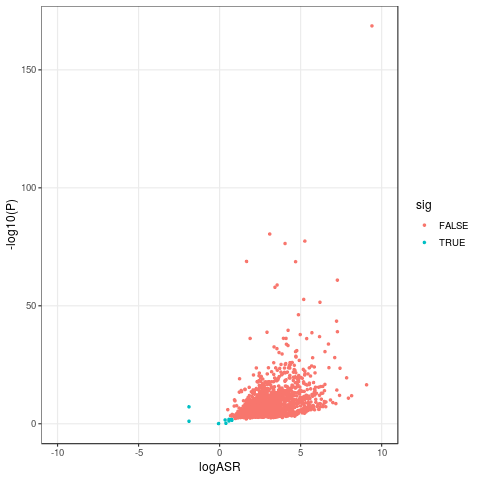

In [41]:
%%R
library(tidyverse)
m <- read_tsv('GROseq/asRNA_antisense_sense_logASR_logit.txt')
m <- m %>% mutate(sig = ifelse(logASR>0.5 & q<0.01, FALSE, TRUE) )
m %>% ggplot(aes(x=logASR, y=-log10(P), color=sig)) + geom_point(size=1) +xlim(c(-10,10)) + theme_bw(12) + theme(panel.grid.minor = element_blank())
#ggsave("GROseq/asRNA_antisense_sense_logASR_logit_volcano.pdf", useDingbats=F, width=4, height=3)

In [ ]:
%%bash
wc -l GROseq/Human.GRC38.96_antisense.asRNA.sig.bed
awk '{if ($2>1 && $4<0.01) print}' GROseq/asRNA_antisense_sense_logASR_logit.txt | cut -f1 | sed '1d' > GROseq/Human.GRC38.96_antisense.asRNA.sig.list
grep -w --color=never -Ff GROseq/Human.GRC38.96_antisense.asRNA.sig.list GROseq/Human.GRC38.96_antisense.asRNA.sig.bed > GROseq/Human.GRC38.96_antisense.asRNA.sig.cor.bed
wc -l GROseq/Human.GRC38.96_antisense.asRNA.sig.cor.bed

In [ ]:
%%bash
grep ENST00000320623 GROseq/asRNA_antisense_sense_logASR_logit.txt

In [ ]:
%%bash
wc -l genome/Human.GRCh38.96.chr.gtf
cut -f1 GROseq/Human.GRC38.96_antisense.asRNA.sig.cor.bed > GROseq/Human.GRC38.96_antisense.asRNA.sig.list
grep -w --color=never -Ff GROseq/Human.GRC38.96_antisense.asRNA.sig.list genome/Human.GRCh38.96.chr.gtf > genome/Human.GRCh38.96.chr.sig.gtf
wc -l genome/Human.GRCh38.96.chr.sig.gtf

In [ ]:
import pyranges as pr
gr = pr.read_gtf("genome/Human.GRCh38.96.chr.sig.gtf")
gdf = gr.df
gdf = gdf[['Chromosome', 'Feature', 'Start', 'End', 'Strand', 'transcript_id']]
gdf['length'] = gdf['End']-gdf['Start']+1
gdf.head()

In [713]:
def get_genomic_pos (loc, starts, lens, strand):
    total = sum(lens)
    if (strand=='-'):
        loc = total-loc
    for i,l in enumerate(lens):
        #print(i, starts[i], loc)
        if loc<=l or i==len(lens)-1:
            break
        loc = loc-l
    return starts[i]+loc,i

In [715]:
## Covert to genomic coordiantes
bed = pd.read_csv('GROseq/Human.GRC38.96_antisense.asRNA.sig.cor.bed', sep="\t", header=None)
out = open('GROseq/Human.GRC38.96_antisense.asRNA.sig.cor.chr.bed', 'wt')
for i in bed.index.tolist():
    if i%100==0:
        print(i)
    tid, tb, te, tn, td, ts, dummy = bed.loc[i,].tolist()
    tmp = gdf.query("Feature=='exon' and transcript_id=='{}'".format(tid))
    gchr = tmp['Chromosome'].tolist()[0]
    gstrand = tmp['Strand'].tolist()[0]
    starts = tmp['Start'].tolist()
    ends = tmp['End'].tolist()
    lens = tmp['length'].tolist()
    if (gstrand=='-'):
        starts.reverse()
        lens.reverse()
        (gb, exb) = get_genomic_pos(te+1, starts, lens, gstrand)
        (ge, exe) = get_genomic_pos(tb+1, starts, lens, gstrand)
        tstrand = '+'
    else:
        gb, exb = get_genomic_pos(tb+1, starts, lens, gstrand)
        ge, exe = get_genomic_pos(te+1, starts, lens, gstrand)
        gb = gb-2
        gr = ge-2
        tstrand = '-'
    if (exe != exb):
        continue
    out.write("{}\t{}\t{}\t{}\t{}\t{}\n".format(gchr, gb, ge, tn, td, tstrand, dummy))
out.close()

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900


In [716]:
%%bash
head GROseq/Human.GRC38.96_antisense.asRNA.sig.cor.bed

ENST00000002125	1586	1929	ENST00000002125:1586-1929	1	-	ENST00000002125-7
ENST00000003100	2398	3007	ENST00000003100:2398-3007	1	-	ENST00000003100-10,ENST00000003100-11
ENST00000005340	2148	2305	ENST00000005340:2148-2305	1	-	ENST00000005340-9
ENST00000012049	1806	2122	ENST00000012049:1806-2122	1	-	ENST00000012049-8
ENST00000012134	5535	5942	ENST00000012134:5535-5942	1	-	ENST00000012134-23
ENST00000014914	4014	4540	ENST00000014914:4014-4540	1	-	ENST00000014914-16,ENST00000014914-17
ENST00000016171	1805	2342	ENST00000016171:1805-2342	1	-	ENST00000016171-8,ENST00000016171-9
ENST00000040663	1442	2023	ENST00000040663:1442-2023	1	-	ENST00000040663-6,ENST00000040663-7
ENST00000040738	3257	3424	ENST00000040738:3257-3424	1	-	ENST00000040738-13,ENST00000040738-14
ENST00000053468	1384	1692	ENST00000053468:1384-1692	1	-	ENST00000053468-6


In [ ]:
## Covert to genomic coordiantes for the negative control set
bed = pd.read_csv('GROseq/Human.GRC38.96_antisense_frags.neg.control.merge.bed', sep="\t", header=None)
out = open('GROseq/Human.GRC38.96_antisense_frags.neg.control.merge.chr.bed', 'wt')
for i in bed.index.tolist():
    if i%100==0:
        print(i)
    tid, tb, te, tn, td, ts, dummy = bed.loc[i,].tolist()
    tmp = gdf.query("Feature=='exon' and transcript_id=='{}'".format(tid))
    if (tmp.empty):
        continue
    gchr = tmp['Chromosome'].tolist()[0]
    gstrand = tmp['Strand'].tolist()[0]
    starts = tmp['Start'].tolist()
    ends = tmp['End'].tolist()
    lens = tmp['length'].tolist()
    if (gstrand=='-'):
        starts.reverse()
        lens.reverse()
        (gb, exb) = get_genomic_pos(te+1, starts, lens, gstrand)
        (ge, exe) = get_genomic_pos(tb+1, starts, lens, gstrand)
        tstrand = '+'
    else:
        gb, exb = get_genomic_pos(tb+1, starts, lens, gstrand)
        ge, exe = get_genomic_pos(te+1, starts, lens, gstrand)
        gb = gb-2
        gr = ge-2
        tstrand = '-'
    out.write("{}\t{}\t{}\t{}\t{}\t{}\n".format(gchr, gb, ge, tn, td, tstrand, dummy))
out.close()

In [717]:
fasta = {}
with open("genome/Human.GRC38.96_cDNA_longest_CDS.fa", "rt") as handle:
    for record in SeqIO.parse(handle, "fasta"):
        fasta[record.id] = str(record.seq)   

In [718]:
from Bio.Seq import Seq

with open("GROseq/Human.GRC38.96_antisense.asRNA.sig.cor.bed", "rt") as handle, open("GROseq/Human.GRC38.96_antisense.asRNA.sig.cor.fa", "wt") as out:
    for l in handle:
        l = re.sub("\s+$", "", l)
        a = l.split('\t')
        s = fasta[a[0]]
        subs = s[int(a[1]):int(a[2])]
        if a[5]=='-':
            subs = Seq(subs).reverse_complement()
        out.write(">{}\n{}\n".format(a[3], subs))

In [719]:
%%bash
wc -l GROseq/Human.GRC38.96_antisense.asRNA.sig.cor.chr.bed

1787 GROseq/Human.GRC38.96_antisense.asRNA.sig.cor.chr.bed


## POLR2A Analysis

In [ ]:
%%bash
mkdir POLR2A_ChIPseq

In [ ]:
%%bash
cd POLR2A_ChIPseq/
#files.txt from ENCODE cart (bed narrowPeak, GRCh38, peaks pre-IDR)
xargs -L 1 curl -O -L < files.txt

In [ ]:
%%bash
gunzip POLR2A_ChIPseq/*.gz

In [ ]:
%%bash
mkdir POLR2A_ChIPseq/combined

In [ ]:
%%bash
cat POLR2A_ChIPseq/*.bed | awk 'OFS="\t" {print $1,$2,$3,"POLR2A_ChIP_peak_" NR,"1\t."}' > POLR2A_ChIPseq/combined/POL2RA_combined.bed

In [720]:
%%bash
awk 'OFS="\t" {if ($6=="+"){print($1, $2-1000, $3, $4, $5, $6)}else{print($1, $2, $3+1000, $4, $5, $6)}}' GROseq/Human.GRC38.96_antisense.asRNA.sig.cor.chr.bed > GROseq/Human.GRC38.96_antisense.asRNA.sig.cor.chr.ext.bed

In [721]:
%%bash
#The negatives are ~400bp longer, so the estimates here are actually more conservative
awk 'OFS="\t" {if ($6=="+"){print($1, $2, $3, $4, $5, $6)}else{print($1, $2, $3, $4, $5, $6)}}' GROseq/Human.GRC38.96_antisense_frags.neg.control.merge.chr.bed > GROseq/Human.GRC38.96_antisense_frags.neg.control.merge.chr.ext.bed

In [722]:
%%bash
intersectBed -wo -a GROseq/Human.GRC38.96_antisense.asRNA.sig.cor.chr.ext.bed -b POLR2A_ChIPseq/combined/POL2RA_combined.bed > POLR2A_ChIPseq/combined/Human.GRC38.96_antisense.asRNA.sig.cor.chr.POL2RA_combined.bed

In [723]:
%%bash
cut -f4 POLR2A_ChIPseq/combined/Human.GRC38.96_antisense.asRNA.sig.cor.chr.POL2RA_combined.bed | sort | uniq -c | awk '{ print $2 "\t" $1}' > POLR2A_ChIPseq/combined/Human.GRC38.96_antisense.asRNA.sig.cor.chr.POL2RA_combined.cnt

In [724]:
%%bash
#neg control
intersectBed -wo -a GROseq/Human.GRC38.96_antisense_frags.neg.control.merge.chr.ext.bed -b POLR2A_ChIPseq/combined/POL2RA_combined.bed > POLR2A_ChIPseq/combined/Human.GRC38.96_antisense_frags.neg.control.merge.chr.ext.POL2RA_combined.bed

In [725]:
%%bash
cut -f4 POLR2A_ChIPseq/combined/Human.GRC38.96_antisense_frags.neg.control.merge.chr.ext.POL2RA_combined.bed | sort | uniq -c | awk '{ print $2 "\t" $1}' > POLR2A_ChIPseq/combined/Human.GRC38.96_antisense_frags.neg.control.merge.chr.ext.POL2RA_combined.cnt

In [24]:
%%R
library(tidyverse)
pol2ra.pos.cnt <- read_tsv('POLR2A_ChIPseq/combined/Human.GRC38.96_antisense.asRNA.sig.cor.chr.POL2RA_combined.cnt', col_names=F)
pol2ra.pos.cnt$X2 <- log2(pol2ra.pos.cnt$X2)
pol2ra.pos.cnt$type <- 'set'

pol2ra.neg.cnt <- read_tsv('POLR2A_ChIPseq/combined/Human.GRC38.96_antisense_frags.neg.control.merge.chr.ext.POL2RA_combined.cnt', col_names=F)
pol2ra.neg.cnt$X2 <- log2(pol2ra.neg.cnt$X2)
pol2ra.neg.cnt$type <- 'control'

th <- median(pol2ra.neg.cnt$X2)+IQR(pol2ra.neg.cnt$X2)
passed <- pol2ra.pos.cnt %>% dplyr::filter(X2>th) %>% dplyr::select(X1) %>% pull()

bed <- read_tsv('GROseq/Human.GRC38.96_antisense.asRNA.sig.cor.chr.bed', col_names=F)
colnames(bed) <- c("chr", "start", "end", "frag", "dummy", "strand")
write_tsv(bed %>% dplyr::filter(frag %in% passed), 'POLR2A_ChIPseq/combined/Human.GRC38.96_antisense.asRNA.sig.cor.chr.polr2a.bed', col_names=F)

bed <- read_tsv('GROseq/Human.GRC38.96_antisense.asRNA.sig.cor.bed', col_names=F)
colnames(bed) <- c("chr", "start", "end", "frag", "dummy", "strand", "transcripts")
write_tsv(bed %>% dplyr::filter(frag %in% passed), 'POLR2A_ChIPseq/combined/Human.GRC38.96_antisense.asRNA.sig.cor.polr2a.bed', col_names=F)

merge <- pol2ra.pos.cnt %>% bind_rows(pol2ra.neg.cnt)
merge %>% ggplot(aes(x=X2, color=type, fill=type)) + geom_density(alpha=0.2) + xlab('log-count POL2RA datasets that match') + xlim(c(0,7)) +
    geom_vline(xintercept=median(pol2ra.neg.cnt$X2), linetype="dashed", color = "black") +
    geom_vline(xintercept=th, linetype="dashed", color = "red") + theme_bw(12) + theme(panel.grid.minor = element_blank(), panel.grid.major = element_blank())
ggsave("POLR2A_ChIPseq/antisense_vs_control_density.pdf", width=4, height=2.5)
#merge %>% ggplot(aes(x=X2, color=type, fill=type)) + stat_ecdf() + xlab('log-count POL2RA datasets that match') + theme_bw()

In [728]:
%%bash
head POLR2A_ChIPseq/combined/Human.GRC38.96_antisense.asRNA.sig.cor.polr2a.bed
wc -l POLR2A_ChIPseq/combined/Human.GRC38.96_antisense.asRNA.sig.cor.polr2a.bed

ENST00000003100	2398	3007	ENST00000003100:2398-3007	1	-	ENST00000003100-10,ENST00000003100-11
ENST00000005340	2148	2305	ENST00000005340:2148-2305	1	-	ENST00000005340-9
ENST00000056233	1227	2019	ENST00000056233:1227-2019	1	-	ENST00000056233-6,ENST00000056233-7
ENST00000056233	2973	3528	ENST00000056233:2973-3528	1	-	ENST00000056233-13
ENST00000170447	2561	2752	ENST00000170447:2561-2752	1	-	ENST00000170447-11
ENST00000181839	77	329	ENST00000181839:77-329	1	-	ENST00000181839-1,ENST00000181839-2
ENST00000192788	6056	6622	ENST00000192788:6056-6622	1	-	ENST00000192788-25,ENST00000192788-26,ENST00000192788-27
ENST00000204726	7425	8328	ENST00000204726:7425-8328	1	-	ENST00000204726-29,ENST00000204726-30,ENST00000204726-33
ENST00000209728	2309	2559	ENST00000209728:2309-2559	1	-	ENST00000209728-9,ENST00000209728-10
ENST00000216034	1327	1712	ENST00000216034:1327-1712	1	-	ENST00000216034-6
308 POLR2A_ChIPseq/combined/Human.GRC38.96_antisense.asRNA.sig.cor.polr2a.bed


## Stranded RNA-seq

In [ ]:
%%bash
for f in 09152015_MDA-LM2_RNA-seq/*.trim.fastq.gz; do
out=${f/.trim.fastq.gz/.cDNA.bam}
echo $f
echo "bowtie2 --sensitive --end-to-end -N 1 -p 4 -x genome/Human.GRC38.96_cDNA_longest_CDS -U $f | samtools view - -F4 -Sb  -h -t  genome/Human.GRC38.96_cDNA_longest_CDS.fa.fai -o $out"
bowtie2 --sensitive --end-to-end -N 1 -p 4 -x genome/Human.GRC38.96_cDNA_longest_CDS -U $f | samtools view - -F4 -Sb  -h -t  genome/Human.GRC38.96_cDNA_longest_CDS.fa.fai -o $out
done


In [ ]:
%%bash
for f in 09152015_MDA-LM2_RNA-seq/*.cDNA.bam; do
samtools flagstat $f | head -n1
done

In [ ]:
%%bash
for f in 09152015_MDA-LM2_RNA-seq/*.cDNA.bam; do
echo $f
samtools view $f | cut -f2 | sort | uniq -c
done

In [ ]:
%%bash
for f in 09152015_MDA-LM2_RNA-seq/*.cDNA.bam; do
out=${f/.cDNA.bam/.sense.gene.cnt}
echo "samtools view $f | awk '{if($2==0) print}' | cut -f3 | sort | uniq -c |  awk '{ print $2 "\t" $1}' > $out"
samtools view $f | awk '{if($2==0) print}' | cut -f3 | sort | uniq -c |  awk '{ print $2 "\t" $1}' > $out
out=${f/.cDNA.bam/.antisense.gene.cnt}
echo "samtools view $f | awk '{if($2==16) print}' | cut -f3 | sort | uniq -c |  awk '{ print $2 "\t" $1}' > $out"
samtools view $f | awk '{if($2==16) print}' | cut -f3 | sort | uniq -c |  awk '{ print $2 "\t" $1}' > $out
done

In [ ]:
%%bash
for f in 09152015_MDA-LM2_RNA-seq/*.cDNA.bam; do
out=${f/.bam/.bed}
echo "bamToBed -i $f > $out"
bamToBed -i $f > $out
done

In [729]:
%%bash
for f in 09152015_MDA-LM2_RNA-seq/*.cDNA.bed; do
out=${f/.cDNA.bed/.sense.frag.cnt}
echo "intersectBed -f 1 -S -wo -a $f -b POLR2A_ChIPseq/combined/Human.GRC38.96_antisense.asRNA.sig.cor.polr2a.bed | cut -f10 | sort | uniq -c |  awk '{ print $2 "\t" $1}' > $out"
intersectBed -f 1 -S -wo -a $f -b POLR2A_ChIPseq/combined/Human.GRC38.96_antisense.asRNA.sig.cor.polr2a.bed | cut -f10 | sort | uniq -c |  awk '{ print $2 "\t" $1}' > $out
out=${f/.cDNA.bed/.antisense.frag.cnt}
echo "intersectBed -f 1 -s -wo -a $f -b POLR2A_ChIPseq/combined/Human.GRC38.96_antisense.asRNA.sig.cor.polr2a.bed | cut -f10 | sort | uniq -c |  awk '{ print $2 "\t" $1}' > $out"
intersectBed -f 1 -s -wo -a $f -b POLR2A_ChIPseq/combined/Human.GRC38.96_antisense.asRNA.sig.cor.polr2a.bed | cut -f10 | sort | uniq -c |  awk '{ print $2 "\t" $1}' > $out
done

intersectBed -f 1 -S -wo -a 09152015_MDA-LM2_RNA-seq/MDA-LM2_r1.cDNA.bed -b POLR2A_ChIPseq/combined/Human.GRC38.96_antisense.asRNA.sig.cor.polr2a.bed | cut -f10 | sort | uniq -c |  awk '{ print  t }' > 09152015_MDA-LM2_RNA-seq/MDA-LM2_r1.sense.frag.cnt
intersectBed -f 1 -s -wo -a 09152015_MDA-LM2_RNA-seq/MDA-LM2_r1.cDNA.bed -b POLR2A_ChIPseq/combined/Human.GRC38.96_antisense.asRNA.sig.cor.polr2a.bed | cut -f10 | sort | uniq -c |  awk '{ print  t }' > 09152015_MDA-LM2_RNA-seq/MDA-LM2_r1.antisense.frag.cnt
intersectBed -f 1 -S -wo -a 09152015_MDA-LM2_RNA-seq/MDA-LM2_r2.cDNA.bed -b POLR2A_ChIPseq/combined/Human.GRC38.96_antisense.asRNA.sig.cor.polr2a.bed | cut -f10 | sort | uniq -c |  awk '{ print  t }' > 09152015_MDA-LM2_RNA-seq/MDA-LM2_r2.sense.frag.cnt
intersectBed -f 1 -s -wo -a 09152015_MDA-LM2_RNA-seq/MDA-LM2_r2.cDNA.bed -b POLR2A_ChIPseq/combined/Human.GRC38.96_antisense.asRNA.sig.cor.polr2a.bed | cut -f10 | sort | uniq -c |  awk '{ print  t }' > 09152015_MDA-LM2_RNA-seq/MDA-LM2_r2

In [730]:
%%R -o frag.df
files <- list.files("./09152015_MDA-LM2_RNA-seq", pattern=".frag.cnt$")
files <- paste0("./09152015_MDA-LM2_RNA-seq/", files)
datalist <- lapply(files, function(x){read.table(file=x,header=FALSE,col.names=c("frag", sub("./09152015_MDA-LM2_RNA-seq/(\\S+)\\.cnt", "\\1", x)))})
m <- Reduce(function(...) merge(..., by=1, all = TRUE), datalist)
rownames(m) <- m[,1]
m <- m[,-1]
m[is.na(m)]<-0
tmp <- m
tmp[tmp>0] <- 1
frag.df <- data.frame(m[rowSums(tmp)==8,])
frag.df$frag <- rownames(frag.df)
head(frag.df)

                          MDA.LM2_r1.antisense.frag MDA.LM2_r1.sense.frag
ENST00000003100:2398-3007                       197                   412
ENST00000056233:1227-2019                       138                  2167
ENST00000056233:2973-3528                       100                   139
ENST00000170447:2561-2752                         3                    37
ENST00000192788:6056-6622                        42                   153
ENST00000204726:7425-8328                        69                   226
                          MDA.LM2_r2.antisense.frag MDA.LM2_r2.sense.frag
ENST00000003100:2398-3007                       257                   498
ENST00000056233:1227-2019                       157                  2463
ENST00000056233:2973-3528                       102                   144
ENST00000170447:2561-2752                         2                    60
ENST00000192788:6056-6622                        36                   131
ENST00000204726:7425-8328             

In [731]:
%%R -o gene.df
files <- list.files("./09152015_MDA-LM2_RNA-seq", pattern="gene.cnt$")
files <- paste0("./09152015_MDA-LM2_RNA-seq/", files)
datalist <- lapply(files, function(x){read.table(file=x,header=FALSE,col.names=c("frag", sub("./09152015_MDA-LM2_RNA-seq/(\\S+)\\.cnt", "\\1", x)))})
m <- Reduce(function(...) merge(..., by=1, all = TRUE), datalist)
rownames(m) <- m[,1]
m <- m[,-1]
m[is.na(m)]<-0
tmp <- m
tmp[tmp>0] <- 1
gene.df <- data.frame(m[rowSums(tmp)==8,])
gene.df$gene <- rownames(gene.df)
head(gene.df)

                MDA.LM2_r1.antisense.gene MDA.LM2_r1.sense.gene
ENST00000000233                         2                   176
ENST00000000412                       112                  2294
ENST00000000442                        29                   598
ENST00000001008                       176                  3139
ENST00000001146                         5                   126
ENST00000002125                        87                   556
                MDA.LM2_r2.antisense.gene MDA.LM2_r2.sense.gene
ENST00000000233                         5                   235
ENST00000000412                       116                  2868
ENST00000000442                        41                   740
ENST00000001008                       192                  3496
ENST00000001146                        12                   178
ENST00000002125                       103                   649
                MDA.Par_r1.antisense.gene MDA.Par_r1.sense.gene
ENST00000000233                        1

In [732]:
%%R -i frag.df,gene.df -o merged.df
library(tidyverse)
frag.df$gene <- gsub(":\\d+-\\d+$", "", frag.df$frag)

merged.df <- frag.df %>% inner_join(gene.df, by="gene")
merged.df <- merged.df[,c(9,seq(1,8), seq(11,18))]
merged.df[,10] <- merged.df[,10]-merged.df[,2]
merged.df[,11] <- merged.df[,11]-merged.df[,3]
merged.df[,12] <- merged.df[,12]-merged.df[,4]
merged.df[,13] <- merged.df[,13]-merged.df[,5]
merged.df[,14] <- merged.df[,14]-merged.df[,6]
merged.df[,15] <- merged.df[,15]-merged.df[,7]
merged.df[,16] <- merged.df[,16]-merged.df[,8]
merged.df[,17] <- merged.df[,17]-merged.df[,9]
head(merged.df)

                       frag MDA.LM2_r1.antisense.frag MDA.LM2_r1.sense.frag
1 ENST00000003100:2398-3007                       197                   412
2 ENST00000056233:1227-2019                       138                  2167
3 ENST00000056233:2973-3528                       100                   139
4 ENST00000170447:2561-2752                         3                    37
5 ENST00000192788:6056-6622                        42                   153
6 ENST00000204726:7425-8328                        69                   226
  MDA.LM2_r2.antisense.frag MDA.LM2_r2.sense.frag MDA.Par_r1.antisense.frag
1                       257                   498                       317
2                       157                  2463                       128
3                       102                   144                        57
4                         2                    60                         3
5                        36                   131                        70
6           

In [733]:
%%R -i merged.df -o fit.s
logit.all<-function(x, design, model, feature.list){
  logit.all.gene<-function(m){
    prep<-data.frame(design,m)
    fit<-glm(model, data=prep, family="binomial"(link="logit"), weights = m)
    sfit<<-summary(fit)
    return(c(t(sfit$coefficients)))
  }
  logit.all.gene_try<-function(m){
    out<-tryCatch(
      {
        result_logistic<-logit.all.gene(m)
      },
      error=function(cond){
        return(rep(NA, times=8))
      }
    )
    return(out)
  }
  logit.x<-t(apply(x, 1, logit.all.gene_try))
  colnames(logit.x)<-apply(expand.grid(colnames(sfit$coefficients), rownames(sfit$coefficients)), 1, paste, collapse=".")
  rownames(logit.x)<-feature.list
  return(logit.x)
}

meta <- data.frame( do.call( rbind, strsplit( colnames(merged.df), '\\.' )[-1] ) )
meta$X1 <- c(rep("LM2",4),rep("MDA",4),rep("LM2",4),rep("MDA",4))
meta$X2 <- c(rep(c("r1", "r1", "r2", "r2"),4))
colnames(meta) <- c('cell.line', 'rep', 'strand', 'feature.type')
meta$feature.type <- factor(meta$feature.type)
meta$feature.type <- relevel(meta$feature.type, ref='gene')
meta$strand <- factor(meta$strand)
meta$strand <- relevel(meta$strand, ref='sense')

fit <- logit.all( merged.df[,-1], meta, feature.type~strand,  merged.df$frag)
fit.s <- fit[,c(5,8)]
colnames(fit.s) <- c("logASR", "P")
fit.s <- cbind(fit.s, p.adjust(fit.s[,'P'], method="fdr"))
colnames(fit.s) <- c("logASR", "P", "q")
write.table(fit.s, "09152015_MDA-LM2_RNA-seq/asRNA_gene_logASR_logit.txt", quote = F, sep="\t", row.names = T, col.names =NA) #ASR=antisense-sense ratio aka enrichment score
fit.s <- as.data.frame(fit.s)
fit.s$frag <- rownames(fit.s)
head(fit)

                          Estimate.(Intercept) Std. Error.(Intercept)
ENST00000003100:2398-3007           -1.5377760             0.02395529
ENST00000056233:1227-2019           -0.9119044             0.01312757
ENST00000056233:2973-3528           -3.8488529             0.04153523
ENST00000170447:2561-2752           -3.3115135             0.06895033
ENST00000192788:6056-6622           -2.4693412             0.03873233
ENST00000204726:7425-8328           -2.7924241             0.02976350
                          z value.(Intercept) Pr(>|z|).(Intercept)
ENST00000003100:2398-3007           -64.19358                    0
ENST00000056233:1227-2019           -69.46481                    0
ENST00000056233:2973-3528           -92.66478                    0
ENST00000170447:2561-2752           -48.02752                    0
ENST00000192788:6056-6622           -63.75400                    0
ENST00000204726:7425-8328           -93.82044                    0
                          Estimate.strand

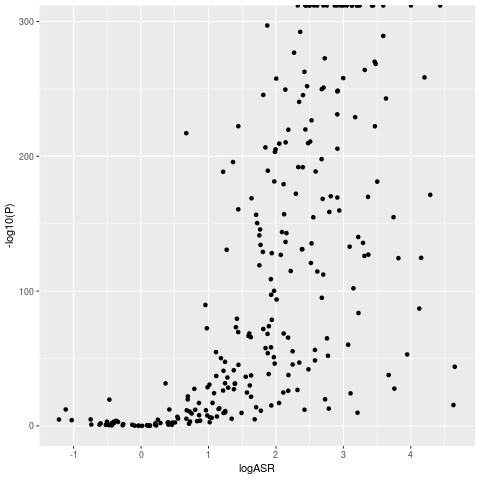

In [734]:
%%R -i fit.s
#fit.s[startsWith(fit.s$frag, 'ENST00000320623'),]
fit.s %>% ggplot(aes(y=-log10(P), x=logASR)) + geom_point() #+ xlim(c(1,20))
#merged.df[startsWith(merged.df$frag, 'ENST00000320623'),]

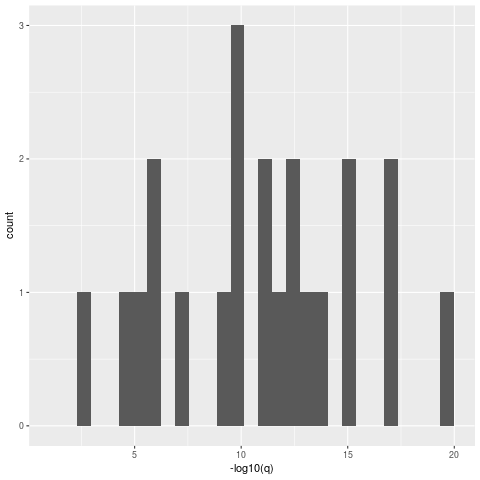

In [735]:
%%R -i fit.s
fit.s %>% filter(logASR>1) %>% ggplot(aes(x=-log10(q))) + geom_histogram() + xlim(c(1,20))

In [736]:
%%R -i fit.s
library(tidyverse)
passed <- fit.s %>% filter(logASR>1 && -log10(q)>5) %>% select(frag) %>% pull()

bed <- read_tsv('POLR2A_ChIPseq/combined/Human.GRC38.96_antisense.asRNA.sig.cor.polr2a.bed', col_names=F)
colnames(bed) <- c("chr", "start", "end", "frag", "dummy", "strand", "transcripts")
write_tsv(bed %>% dplyr::filter(frag %in% passed), '09152015_MDA-LM2_RNA-seq/Human.GRC38.96_antisense.final.bed', col_names=F)

In [737]:
%%bash
head 09152015_MDA-LM2_RNA-seq/Human.GRC38.96_antisense.final.bed
wc -l 09152015_MDA-LM2_RNA-seq/Human.GRC38.96_antisense.final.bed

ENST00000003100	2398	3007	ENST00000003100:2398-3007	1	-	ENST00000003100-10,ENST00000003100-11
ENST00000056233	1227	2019	ENST00000056233:1227-2019	1	-	ENST00000056233-6,ENST00000056233-7
ENST00000056233	2973	3528	ENST00000056233:2973-3528	1	-	ENST00000056233-13
ENST00000170447	2561	2752	ENST00000170447:2561-2752	1	-	ENST00000170447-11
ENST00000192788	6056	6622	ENST00000192788:6056-6622	1	-	ENST00000192788-25,ENST00000192788-26,ENST00000192788-27
ENST00000204726	7425	8328	ENST00000204726:7425-8328	1	-	ENST00000204726-29,ENST00000204726-30,ENST00000204726-33
ENST00000209728	2309	2559	ENST00000209728:2309-2559	1	-	ENST00000209728-9,ENST00000209728-10
ENST00000216034	1327	1712	ENST00000216034:1327-1712	1	-	ENST00000216034-6
ENST00000216099	44	219	ENST00000216099:44-219	1	-	ENST00000216099-1
ENST00000219313	1008	1490	ENST00000219313:1008-1490	1	-	ENST00000219313-5
262 09152015_MDA-LM2_RNA-seq/Human.GRC38.96_antisense.final.bed


## Filtering those asRNAs that overlap other genes and are likely artifacts

In [739]:
## Covert to genomic coordiantes for the negative control set
bed = pd.read_csv('09152015_MDA-LM2_RNA-seq/Human.GRC38.96_antisense.final.bed', sep="\t", header=None)
out = open('09152015_MDA-LM2_RNA-seq/Human.GRC38.96_antisense.final.chr.bed', 'wt')
for i in bed.index.tolist():
    if i%100==0:
        print(i)
    tid, tb, te, tn, td, ts, dummy = bed.loc[i,].tolist()
    tmp = gdf.query("Feature=='exon' and transcript_id=='{}'".format(tid))
    if (tmp.empty):
        continue
    gchr = tmp['Chromosome'].tolist()[0]
    gstrand = tmp['Strand'].tolist()[0]
    starts = tmp['Start'].tolist()
    ends = tmp['End'].tolist()
    lens = tmp['length'].tolist()
    if (gstrand=='-'):
        starts.reverse()
        lens.reverse()
        gb, exb = get_genomic_pos(te+1, starts, lens, gstrand)
        ge, exe = get_genomic_pos(tb+1, starts, lens, gstrand)
        tstrand = '+'
    else:
        gb, exb = get_genomic_pos(tb+1, starts, lens, gstrand)
        ge, exe = get_genomic_pos(te+1, starts, lens, gstrand)
        gb = gb-2
        ge = ge-2
        tstrand = '-'
    if (exe != exb):
        continue
    out.write("{}\t{}\t{}\t{}\t{}\t{}\n".format(gchr, gb, ge, tn, td, tstrand, dummy))
out.close()

0
100
200


In [740]:
%%bash
wc -l 09152015_MDA-LM2_RNA-seq/Human.GRC38.96_antisense.final.chr.bed

262 09152015_MDA-LM2_RNA-seq/Human.GRC38.96_antisense.final.chr.bed


In [4]:
%%bash
grep -E -v --color=never "antisense|pseudogene" genome/gencode.v28.annotation.c.gtf > genome/gencode.v28.annotation.c.filt.gtf

In [7]:
%%bash
intersectBed -u -s -a 09152015_MDA-LM2_RNA-seq/Human.GRC38.96_antisense.final.chr.bed -b genome/gencode.v28.annotation.c.filt.gtf | cut -f4 > filter.list

In [9]:
%%bash
grep -v --color=never -Ff filter.list 09152015_MDA-LM2_RNA-seq/Human.GRC38.96_antisense.final.bed > Human.GRC38.96_antisense.final.filt.bed
wc -l Human.GRC38.96_antisense.final.filt.bed

204 Human.GRC38.96_antisense.final.filt.bed


In [10]:
%%bash
grep -v --color=never -Ff filter.list 09152015_MDA-LM2_RNA-seq/Human.GRC38.96_antisense.final.chr.bed > Human.GRC38.96_antisense.final.chr.filt.bed
wc -l Human.GRC38.96_antisense.final.chr.filt.bed

204 Human.GRC38.96_antisense.final.chr.filt.bed


## Comparison of antisense RNA expression in poorly and highly metastatic cells

In [13]:
# Extract the identified sequences
fasta = {}
with open("genome/Human.GRC38.96_cDNA_longest_CDS.fa", "rt") as handle:
    for record in SeqIO.parse(handle, "fasta"):
        fasta[record.id] = str(record.seq)   

from Bio.Seq import Seq

with open("Human.GRC38.96_antisense.final.filt.bed", "rt") as handle, open("Human.GRC38.96_antisense.final.filt.fa", "wt") as out:
    for l in handle:
        l = re.sub("\s+$", "", l)
        a = l.split('\t')
        s = fasta[a[0]]
        subs = s[int(a[1]):int(a[2])]
        if a[5]=='-':
            subs = Seq(subs).reverse_complement()
        out.write(">{}\n{}\n".format(a[3], subs))

In [741]:
%%bash
awk '{ if ($0 ~ "transcript_id") print $0 ; else print $0" transcript_id "";"; }' genome/gencode.v28.annotation.gtf | gtf2bed - | grep -w "gene" > genome/gencode.v28.annotation.bed

In [14]:
%%bash
intersectBed -s -u -f 0.75 -a Human.GRC38.96_antisense.final.chr.filt.bed -b genome/gencode.v28.annotation.bed > Human.GRC38.96_antisense.final.chr.ov.bed

In [15]:
%%bash
intersectBed -s -wo -f 0.75 -b Human.GRC38.96_antisense.final.chr.ov.bed -a genome/gencode.v28.annotation.bed > genome/gencode.v28.annotation.asRNA.matched.bed

In [16]:
%%bash
cat genome/gencode.v28.annotation.asRNA.matched.bed

chr16	69709873	69710583	ENSG00000261602.1	.	+	HAVANA	gene	.	gene_id "ENSG00000261602.1"; gene_type "antisense"; gene_name "CTD-2033A16.1"; level 2; havana_gene "OTTHUMG00000176835.1"; transcript_id ;	chr16	69709869	69710576	ENST00000320623:1345-2052	1	+	703


In [17]:
%%bash
#remove previously annotated 
cut -f14,4 genome/gencode.v28.annotation.asRNA.matched.bed  > genome/gencode.v28.annotation.asRNA.matched.list
cat genome/gencode.v28.annotation.asRNA.matched.list

ENSG00000261602.1	ENST00000320623:1345-2052


In [18]:
exclude = [line.rstrip('\n').split('\t')[1] for line in open('genome/gencode.v28.annotation.asRNA.matched.list')]
print(exclude)

['ENST00000320623:1345-2052']


In [19]:
import gzip
from Bio import SeqIO
# Merge the two sets: sense/antisense

out = gzip.open("genome/gencode.v28.transcripts.combined.fa.gz", "wt")
tx2gene = open("genome/gencode.v28.transcripts.combined.tx2gene.cvs", "wt")
tx2gene.write("TXNAME\tGENEID\n")

with gzip.open("genome/gencode.v28.transcripts.fa.gz", "rt") as handle:
    for record in SeqIO.parse(handle, "fasta"):
        txid = record.id.split("|")[0]
        gid = record.id.split("|")[1]
        out.write(">{}\n{}\n".format(txid, str(record.seq)))
        tx2gene.write("{}\t{}\n".format(txid,gid))

with open("Human.GRC38.96_antisense.final.filt.fa", "rt") as handle:
    for record in SeqIO.parse(handle, "fasta"):
        txid = record.id
        if (txid in exclude):
            continue
        out.write(">{}\n{}\n".format(txid, str(record.seq)))
        tx2gene.write("{}\t{}\n".format(txid,txid))
out.close()
tx2gene.close()

In [ ]:
%%bash
salmon index -t genome/gencode.v28.transcripts.combined.fa.gz -i genome/gencode.v28.transcripts.combined.salmon.index

In [ ]:
%%bash
for f in 09152015_MDA-LM2_RNA-seq/*.trim.fastq.gz; do
out=${f/.trim.fastq.gz/_salmon}
echo "salmon quant --validateMappings -i genome/gencode.v28.transcripts.combined.salmon.index -l SF -r $f -p 24 -o $out"; 
salmon quant --validateMappings -i genome/gencode.v28.transcripts.combined.salmon.index -l SF -r $f -p 4 -o $out &
done

In [28]:
%%R
#Transcripts
library(tximport)
library(readr)

files <- list.files("09152015_MDA-LM2_RNA-seq", pattern="quant.sf",full.names = TRUE, recursive=T)

tx2gene <- read_tsv("genome/gencode.v28.transcripts.combined.tx2gene.cvs")

names(files) <- gsub("09152015_MDA-LM2_RNA-seq/(\\S+)_salmon/quant.sf","\\1",files)
txi <- tximport(files, type = "salmon", txOut=T)

txi.gene <- summarizeToGene(txi, tx2gene)
head(txi.gene$counts)
cond <- c("LM2", "LM2", "MDA", "MDA")
colData <- data.frame(cond, row.names=colnames(txi.gene$abundance))
library(DESeq2)
dds <- DESeqDataSetFromTximport(txi.gene, colData, ~cond)
dds$cond<- relevel(dds$cond, ref="MDA")
dds <- DESeq(dds)
res.g.gene <- results(dds)
#write.table(txi.gene$abundance, "09152015_MDA-LM2_RNA-seq/gene_abudance_salmon.txt", sep="\t", quote=FALSE, col.names=NA )
#write.table(txi.gene$counts, "09152015_MDA-LM2_RNA-seq/gene_ncount_salmon.txt", sep="\t", quote=FALSE, col.names=NA )

cond <- c("LM2", "LM2", "MDA", "MDA")
colData <- data.frame(cond, row.names=colnames(txi$abundance))
library(DESeq2)
dds <- DESeqDataSetFromTximport(txi, colData, ~cond)
dds$cond<- relevel(dds$cond, ref="MDA")
dds <- DESeq(dds)
res <- results(dds)
#write.table(txi$abundance, "09152015_MDA-LM2_RNA-seq/tx_abudance_salmon.txt", sep="\t", quote=FALSE, col.names=NA )
#write.table(txi$counts, "09152015_MDA-LM2_RNA-seq/tx_ncount_salmon.txt", sep="\t", quote=FALSE, col.names=NA )
head(res)

log2 fold change (MLE): cond LM2 vs MDA 
Wald test p-value: cond LM2 vs MDA 
DataFrame with 6 rows and 6 columns
                          baseMean     log2FoldChange            lfcSE
                         <numeric>          <numeric>        <numeric>
ENST00000456328.2 6.28601808783261  -1.63594870900976  2.4236349311132
ENST00000450305.2                0                 NA               NA
ENST00000488147.1 2.57331287127224  0.838294271307313 4.33677596058183
ENST00000619216.1  1.2350387705869 -0.288548329319094 3.71224218929596
ENST00000473358.1                0                 NA               NA
ENST00000469289.1                0                 NA               NA
                                 stat            pvalue              padj
                            <numeric>         <numeric>         <numeric>
ENST00000456328.2  -0.674997990831216 0.499677041438402 0.999893615869857
ENST00000450305.2                  NA                NA                NA
ENST00000488147.1   0.1

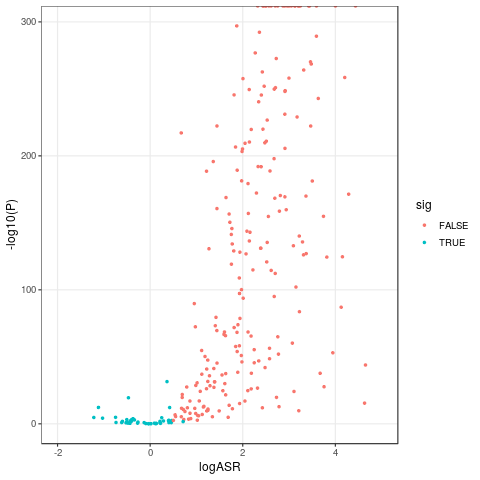

In [3]:
%%R
library(tidyverse)
m <- read_tsv('09152015_MDA-LM2_RNA-seq/asRNA_gene_logASR_logit.txt')
m <- m %>% mutate(sig = ifelse(logASR>0.5 & q<0.01, FALSE, TRUE) )
m %>% ggplot(aes(x=logASR, y=-log10(P), color=sig)) + geom_point(size=1) +xlim(c(-2,5)) + theme_bw(12) + theme(panel.grid.minor = element_blank())
#ggsave("09152015_MDA-LM2_RNA-seq/asRNA_gene_logASR_logit_volcano.pdf", useDingbats=F, width=4, height=3)

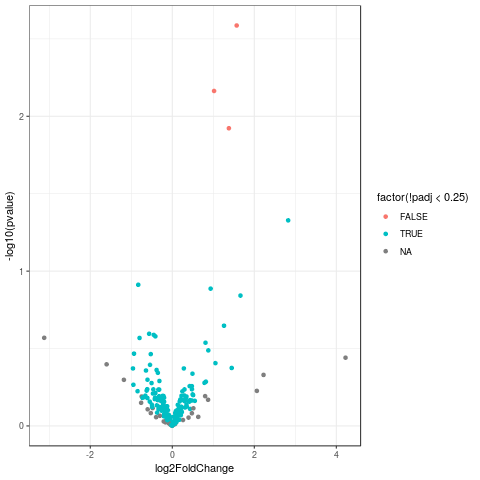

In [29]:
%%R
library(tidyverse)
## annotated asRNAs:
matched <- read_tsv('genome/gencode.v28.annotation.asRNA.matched.list', col_names=F)
colnames(matched) <- c("GENEID", "TXNAME")
list.m <- matched %>% dplyr::left_join(tx2gene, by = 'GENEID')
res$tx <- rownames(res)
res[list.m$TXNAME.y,'tx'] <- list.m$TXNAME.x
res <- as_tibble(res)
as.rna <- grepl("\\S+:\\d+-\\d+", res$tx)
res.as <- res %>% filter(as.rna)
res.g <- res %>% filter(!as.rna)
#as.rna
res.as <- res.as %>% mutate(gene=gsub(":\\d+-\\d+", "", tx))
res.g <- res.g %>% mutate(gene=gsub("\\.\\d+", "", tx))
res.as %>% ggplot(aes(x=log2FoldChange, y=-log10(pvalue), color=factor(!padj<0.25))) + geom_point() + theme_bw()
#write_tsv(res.as, '09152015_MDA-LM2_RNA-seq/asRNA_salmon_logFC.txt')
#ggsave("antisense_MDA-LM2_volcano.pdf", useDingbats=F)


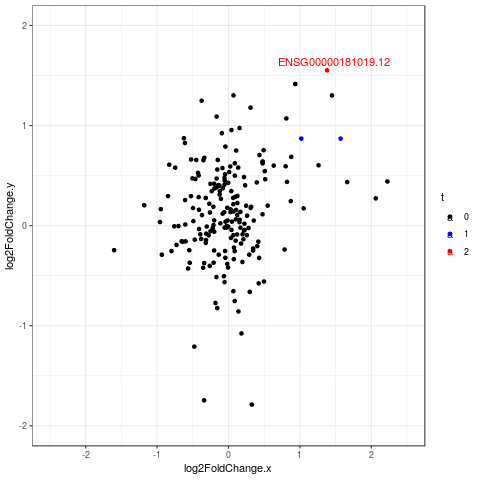

In [5]:
%%R
library(ggrepel)
library(tidyverse)
#res.as$gene
tx2gene <- tx2gene %>% mutate(txid=gsub("\\.\\d+", "",TXNAME))
res.g.gene$GENEID <- rownames(res.g.gene)
res.g.gene <- as_tibble(res.g.gene)
merged <- inner_join(res.as, tx2gene, by=c('gene'='txid'))
merged <- inner_join(merged, res.g.gene, by='GENEID')
merged <- merged %>% mutate(padj.x = ifelse(is.na(padj.x),1,padj.x))
merged <- merged %>% mutate( t = factor(ifelse(GENEID=='ENSG00000181019.12', 2, ifelse(padj.x<0.25,1,0))))
merged <- merged %>% mutate( label = ifelse(t==2, GENEID, ""))
merged %>% ggplot(aes(x=log2FoldChange.x, y=log2FoldChange.y, color=t, label=label)) + geom_point() + ylim(c(-2,2)) + scale_colour_manual(values=c("0"="black", "1"="blue", "2"="red")) + geom_text_repel() + xlim(c(-2.5,2.5)) + theme_bw()
#ggsave("antisense_vs_sense_MDA-LM2_logFC.pdf", useDingbats=F)

In [28]:
%%R -i merged
merged %>% filter(t==1 | t==2) %>% select(tx, gene, TXNAME, GENEID)

# A tibble: 3 x 4
  tx                        gene            TXNAME            GENEID            
  <chr>                     <chr>           <chr>             <chr>             
1 ENST00000320623:1345-2052 ENST00000320623 ENST00000320623.9 ENSG00000181019.12
2 ENST00000056233:1227-2019 ENST00000056233 ENST00000056233.3 ENSG00000050344.8 
3 ENST00000056233:2973-3528 ENST00000056233 ENST00000056233.3 ENSG00000050344.8 


#### Selected Genes
NQO1, NFE2L3, MRFAP1


In [29]:
%%R -i res,res.as,res.g
selected <- c("ENST00000320623:1345-2052", "ENST00000056233:1227-2019", "ENST00000056233:2973-3528")
res.as[res.as$tx %in% selected,] %>% select (-c(lfcSE, stat,baseMean))
#txi$abundance[startsWith(rownames(txi$abundance), 'ENST00000320623'),]

# A tibble: 3 x 5
  log2FoldChange  pvalue   padj tx                        gene           
           <dbl>   <dbl>  <dbl> <chr>                     <chr>          
1           1.38 0.0119  0.163  ENST00000320623:1345-2052 ENST00000320623
2           1.02 0.00686 0.111  ENST00000056233:1227-2019 ENST00000056233
3           1.57 0.00259 0.0543 ENST00000056233:2973-3528 ENST00000056233


In [30]:
exclude

['ENST00000320623:1345-2052']

In [31]:
%%bash
grep -A1 -E "ENST00000056233:1227-2019|ENST00000056233:2973-3528" Human.GRC38.96_antisense.final.filt.fa

>ENST00000056233:1227-2019
TCTGTCAGATAATATCTACTTAACATGCTATTGAAAGAATCAACAGGCATGCCGACAATTTCATCTACAGAAAAAGGGATATGCAAAGCTTTAGCACGCTGTTCATCACGGCTCAAGTTTCTATCTGTGTCTTCAAGGTATCTACTCCTTATCTTCTGTGACTTCCCAGGCCACGGAAAAGGTTCAGAAGTAGATTCTGGTGCAGTTGGCTGTAAGTGGTAAGTGTGGTTATGAAATACGTGTTGAAATGTAAGATCTCCATGGAAATCAGAATCACTTTGATCCAAGTGACAAAGCTTACTGGGTTCTGGGTAGTAGCCACCTACAGCACCTTCTAAGTCATGATGGGAACTAGATTCATGGTCAGTGCAATAACCTATAGCACCTTCATCACACACAGAGTGAGAGGAATTAGACTTGATGACAGAGGTATTATTGTGACTTGAATCTAAAGAAAGGCCAGAATCAGAATCTGGTTCATCAAAAAGCTGAGAAACATCGATTGGATCAAAGTTGTCTTCTGTGGCCAATGACATTAAGTTTATCTCATCAAATATATTTATGTCAAGGTCATACAGTAGGTCTTGGCTTGTTAGATTCCTCATATGATTGTCAACCGGTGAAAGAAATCCTGTCAAATTAGTTCCAGGAAGGGTTTGCTCAGGATTGGTGGTATGAGAATTTAACTGCAGAAATGGTTCTTGTGACTGTGAAGTCCTTGCTGTTGGATCTCTTCTAAATGTATTGTTGGGACAAAGCAAGATGGCCTCATGAAGATTCACATCCTGACTT
>ENST00000056233:2973-3528
TCTAGGTGAGGTCATTGCTGTCTTCAAAAAATTCAGCAATCTCCTGTTTACTGTTCTAGTGAACTTAAGTGAGGTTTTCATTTCAAATGCTATTATTTCTAGAATTTACCTTACCCTGGTTTATTTTCAAATTCACCTGTTTTTTTTCCCTTA

In [32]:
%%bash
grep -A1 -E "ENST00000056233:1227-2019|ENST00000056233:2973-3528" Human.GRC38.96_antisense.final.chr.filt.bed

chr7	26184624	26185416	ENST00000056233:1227-2019	1	-
chr7	26186370	26186925	ENST00000056233:2973-3528	1	-
chr6	34874003	34874569	ENST00000192788:6056-6622	1	-


### Find the enrichment between annotated asRNAs and those identified by iRAs

In [2]:
%load_ext rpy2.ipython
import warnings
warnings.filterwarnings('ignore')

/avicenna/hani/anaconda3/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:17: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


In [3]:
%%R
library(tidyverse)
m <- read_tsv('09152015_MDA-LM2_RNA-seq/tx_abudance_salmon.txt')
m

# A tibble: 203,230 x 5
   X1                `MDA-LM2_r1` `MDA-LM2_r2` `MDA-Par_r1` `MDA-Par_r2`
   <chr>                    <dbl>        <dbl>        <dbl>        <dbl>
 1 ENST00000456328.2       0.0277       0            0.0454       0.0235
 2 ENST00000450305.2       0            0            0            0     
 3 ENST00000488147.1       0            0.0386       0.0165       0     
 4 ENST00000619216.1       0            3.91         0.896        3.84  
 5 ENST00000473358.1       0            0            0            0     
 6 ENST00000469289.1       0            0            0            0     
 7 ENST00000607096.1       0            0            0            0     
 8 ENST00000417324.1       0            0            0            0     
 9 ENST00000461467.1       0.499        0.331        0.251        0.663 
10 ENST00000606857.1       0            0            0            0     
# … with 203,220 more rows


In [5]:
%%R
quantile(rowSums(select(m,-X1)), seq(0,1,0.1))

          0%          10%          20%          30%          40%          50% 
0.000000e+00 0.000000e+00 0.000000e+00 1.486200e-02 5.021400e-02 1.502095e-01 
         60%          70%          80%          90%         100% 
3.941636e-01 9.135541e-01 2.101013e+00 6.130537e+00 4.988775e+05 


In [9]:
%%R
th <- quantile(rowSums(select(m,-X1)), 0.75)
expressed.tx <- m %>% mutate(sums = rowSums(.[2:5])) %>% filter(sums>th) %>% pull(X1)
head(expressed.tx)

[1] "ENST00000619216.1" "ENST00000461467.1" "ENST00000494149.2"
[4] "ENST00000595919.1" "ENST00000493797.1" "ENST00000484859.1"


In [15]:
%%R
write.table(matrix(expressed.tx, length(expressed.tx), 1), '09152015_MDA-LM2_RNA-seq/tx_abudance_salmon_expressed.list', quote=F, col.names=F, row.names=F)

In [19]:
%%bash
grep -Ff 09152015_MDA-LM2_RNA-seq/tx_abudance_salmon_expressed.list genome/gencode.v28.transcripts.combined.tx2gene.cvs | cut -f2 | sort -u \
       > 09152015_MDA-LM2_RNA-seq/tx_abudance_salmon_expressed_genes.list
head 09152015_MDA-LM2_RNA-seq/tx_abudance_salmon_expressed_genes.list

ENSG00000000003.14
ENSG00000000419.12
ENSG00000000457.13
ENSG00000000460.16
ENSG00000000971.15
ENSG00000001036.13
ENSG00000001084.11
ENSG00000001167.14
ENSG00000001460.17
ENSG00000001461.16


In [29]:
%%bash
grep -w gene genome/gencode.v28.annotation.c.gtf | \
grep -E --color=never "antisense|pseudogene" | \
grep -Ff 09152015_MDA-LM2_RNA-seq/tx_abudance_salmon_expressed_genes.list - | wc -l

2271


In [28]:
%%bash
grep -w gene genome/gencode.v28.annotation.c.gtf | \
grep -Ff 09152015_MDA-LM2_RNA-seq/tx_abudance_salmon_expressed_genes.list - | wc -l

17205


In [35]:
%%bash
grep -w gene genome/gencode.v28.annotation.c.gtf | \
grep -E --color=never "antisense|pseudogene" > genome/gencode.v28.annotated.asRNA.gtf
#grep -Ff 09152015_MDA-LM2_RNA-seq/tx_abudance_salmon_expressed_genes.list - > genome/gencode.v28.annotated.asRNA.gtf

In [43]:
%%bash
intersectBed -u -f 0.75 -s -a 09152015_MDA-LM2_RNA-seq/Human.GRC38.96_antisense.final.chr.bed -b genome/gencode.v28.annotated.asRNA.gtf | wc -l

20


In [33]:
%%bash
wc -l 09152015_MDA-LM2_RNA-seq/Human.GRC38.96_antisense.final.chr.bed

262 09152015_MDA-LM2_RNA-seq/Human.GRC38.96_antisense.final.chr.bed


In [38]:
!wc -l genome/gencode.v28.annotated.asRNA.gtf

20223 genome/gencode.v28.annotated.asRNA.gtf


In [40]:
from scipy.stats import hypergeom
hypergeom.cdf(23, 58377, 20223, 262)

1.1317247759471448e-22

In [39]:
!grep -w gene genome/gencode.v28.annotation.c.gtf | wc -l

58377
